<div class="alert alert-block alert-info">
    <h2><center>Distracted Driver Detection Using CNN</center></h2>
    <center><p>Languaje used: Python</p>
        <p>Framework used: tf.keras</p>
    </center>
</div>

## Libraries

In [3]:
#Files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

#CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

#VIS
from keras.utils.vis_utils import plot_model

## Preprocessing data

In [4]:
def _prepareData(path): 
    '''
    parameters: path(STR) of the directory and flag(INT) to know if we prepare data of training or testing
    return: (LIST) of images of the dataset and the (LIST) of labels
    
    For training:
    -Read images of every directory and extract all images
    -Resize to (128,128,3)
    -Read the directory name and asign as a class
    '''
    imgsList = []
    labels = []
    for directory in sorted(glob.glob(os.path.join(path, '*')), key = lambda k: k.split("/")[-1]):
            for imgs in glob.glob(os.path.join(directory,'*.jpg')):
                img_cv = cv2.imread(imgs)
                img_cv_r = cv2.resize(img_cv,(128,128))
                imgsList.append(img_cv_r)
                labels.append(int(directory.split("/")[-1].replace('c','')))
    
    X_Train, X_Test, Y_Train, Y_Test =  train_test_split(imgsList,labels, test_size = 0.2)
    Y_Train = tf.keras.utils.to_categorical(Y_Train, num_classes=10)
    Y_Test = tf.keras.utils.to_categorical(Y_Test, num_classes=10)

    return np.array(X_Train), np.array(X_Test), Y_Train, Y_Test

## Get Data

In [5]:
#Paths
pathTrain_Images = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train/"
pathPropagate_Images =  "/kaggle/input/state-farm-distracted-driver-detection/imgs/test/"

#List of Images for Train and Test
X_Train, X_Test, Y_Train, Y_Test = _prepareData(pathTrain_Images)

print("Size X_Train: {}, Size Y_Train: {}".format(len(X_Train),len(Y_Train)))
print("Size X_Test: {}, Size Y_Test: {}".format(len(X_Test),len(Y_Test)))

Size X_Train: 17939, Size Y_Train: 17939
Size X_Test: 4485, Size Y_Test: 4485


## Check data integrity

### Classes:
* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

17939
(128, 128, 3)


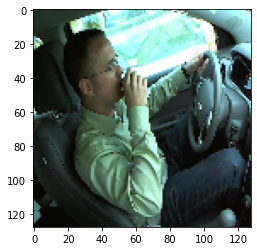

Class: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [6]:
print(len(X_Train))
print(X_Train[202].shape)
im = X_Train[202]
RGB_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_im)
plt.show()
print("Class: {}".format(Y_Train[202]))

## Check data distribution

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

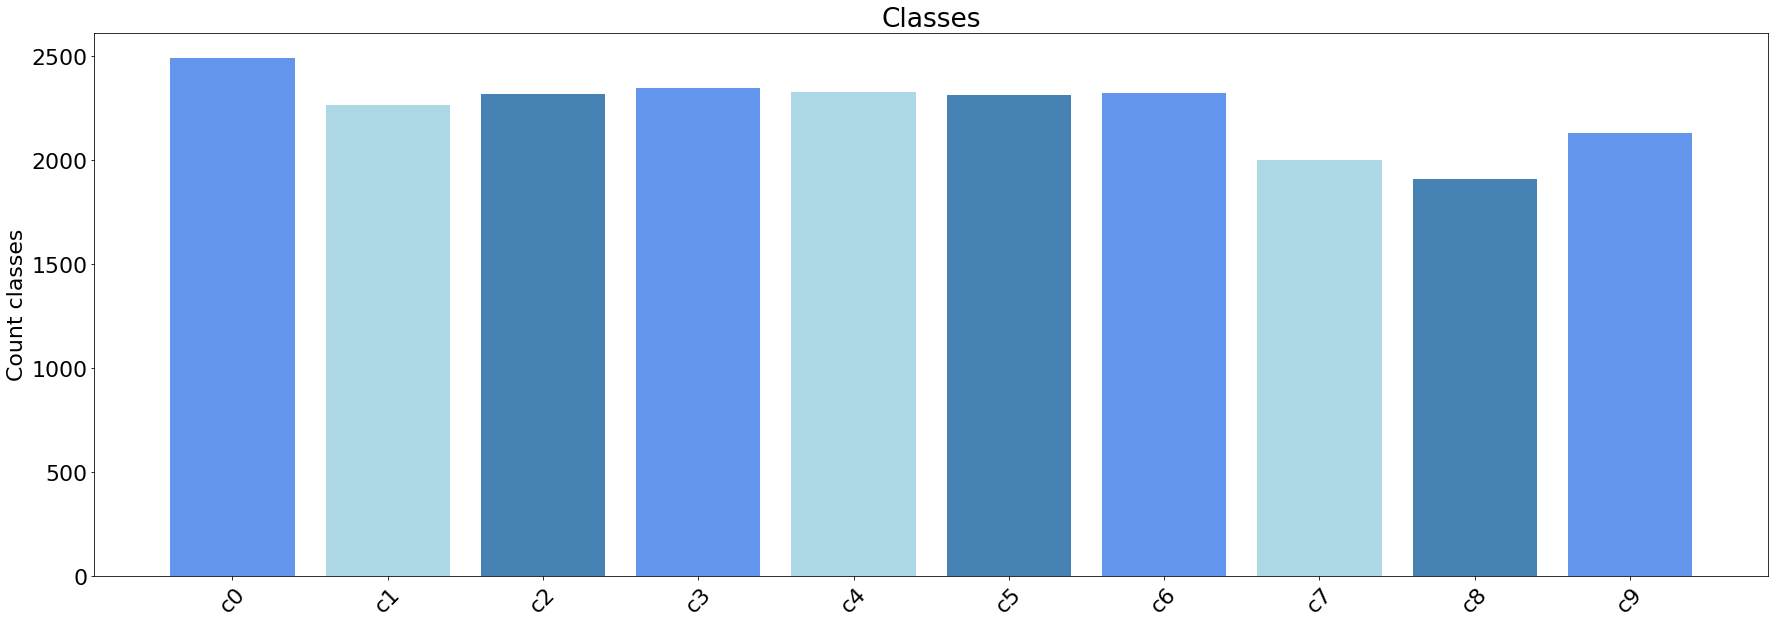

In [7]:
data_file = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
data_classes = data_file.loc[:,['classname','img']].groupby(by='classname').count().reset_index()

data_x = list(pd.unique(data_file['classname']))
data_y =list(data_classes['img'])

# Parámetros de ploteo (Se va a generar un plot diferente para cada Clase)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,10))
plt.bar(data_x, data_y, color=['cornflowerblue', 'lightblue', 'steelblue'])  
plt.ylabel('Count classes')
plt.title('Classes')
plt.xticks(rotation=45)

# Create architecture

In [16]:

model = keras.models.Sequential()

model.add(keras.layers.InputLayer(
    input_shape=(128, 128, 3)
))

model.add(
    keras.layers.Conv2D(
        filters=64,
        kernel_size=(3,3),
        strides = (1,1),
        padding='same',
        activation='relu',
        name='Conv_1'))
model.add(
    keras.layers.Conv2D(
        filters=64,
        kernel_size=(3,3),
        strides = (1,1),
        padding='same',
        activation='relu',
        name='Conv_2'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_1'))#Image_size: 32*64*64(32 filters,image_size 64*64)

model.add(
    keras.layers.Conv2D(
        filters = 128,
        kernel_size = (3,3),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_3'))
model.add(
    keras.layers.Conv2D(
        filters = 128,
        kernel_size = (3,3),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_4'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_3'))#Image_size: 64*32*32(64 filters,image_size 32*32)

model.add(
    keras.layers.Conv2D(
        filters = 256,
        kernel_size = (3,3),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_5'))

model.add(
    keras.layers.Conv2D(
        filters = 256,
        kernel_size = (3,3),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_6'))

model.add(
    keras.layers.Conv2D(
        filters = 256,
        kernel_size = (3,3),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_7'))

model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_4'))#Image_size: 128*16*16(128 filters,image_size 16*16)

model.add(
    keras.layers.Conv2D(
        filters = 512,
        kernel_size = (3,3),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_8'))
model.add(
    keras.layers.Conv2D(
        filters = 512,
        kernel_size = (3,3),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_9'))
model.add(
    keras.layers.Conv2D(
        filters = 512,
        kernel_size = (3,3),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_10'))


model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_5'))#Image_size: 256*8*8(256 filters,image_size 8*8)
model.add(
    keras.layers.Conv2D(
        filters = 512,
        kernel_size = (3,3),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_11'))
model.add(
    keras.layers.Conv2D(
        filters = 512,
        kernel_size = (3,3),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_12'))
model.add(
    keras.layers.Conv2D(
        filters = 512,
        kernel_size = (3,3),
        strides = (1,1),
        padding = 'same',
        activation = 'relu',
        name = 'Conv_13'))
model.add(
    keras.layers.MaxPool2D(
        pool_size = (2,2),
        name = 'Pool_6'))#Image_size: 256*8*8(256 filters,image_size 8*8)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=4096, activation='relu',name = 'fc_1'))

model.add(keras.layers.Dense(units=4096, activation='relu',name = 'fc_2'))
model.add(keras.layers.Dense(units=10,activation='softmax',name = 'fc_3'))
model.save('/tmp/model')
#model.compute_output_shape(input_shape=(256,8,8,1))

In [17]:
tf.random.set_seed(1)
#model.build(input_shape=(None,128,128,3))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False), metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
Conv_2 (Conv2D)              (None, 128, 128, 64)      36928     
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 64, 64, 64)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 64, 64, 128)       73856     
_________________________________________________________________
Conv_4 (Conv2D)              (None, 64, 64, 128)       147584    
_________________________________________________________________
Pool_3 (MaxPooling2D)        (None, 32, 32, 128)       0         
_________________________________________________________________
Conv_5 (Conv2D)              (None, 32, 32, 256)      

## Train model

In [18]:
history = model.fit(x = X_Train, y=Y_Train,epochs = 10, batch_size = 500, verbose = 1,validation_split=0.2)

Epoch 1/10
29/29 [==============================] - 40s 1s/step - loss: 83.6624 - accuracy: 0.1126 - val_loss: 2.5098 - val_accuracy: 0.1093
Epoch 2/10
29/29 [==============================] - 34s 1s/step - loss: 2.3049 - accuracy: 0.1153 - val_loss: 2.2875 - val_accuracy: 0.1302
Epoch 3/10
29/29 [==============================] - 34s 1s/step - loss: 2.1818 - accuracy: 0.1844 - val_loss: 1.7929 - val_accuracy: 0.3643
Epoch 4/10
29/29 [==============================] - 34s 1s/step - loss: 1.3766 - accuracy: 0.4761 - val_loss: 1.0268 - val_accuracy: 0.6054
Epoch 5/10
29/29 [==============================] - 34s 1s/step - loss: 0.7429 - accuracy: 0.7369 - val_loss: 0.5087 - val_accuracy: 0.8294
Epoch 6/10
29/29 [==============================] - 34s 1s/step - loss: 0.3143 - accuracy: 0.8967 - val_loss: 0.2818 - val_accuracy: 0.9114
Epoch 7/10
29/29 [==============================] - 34s 1s/step - loss: 0.1635 - accuracy: 0.9466 - val_loss: 0.1738 - val_accuracy: 0.9479
Epoch 8/10
29/29 [=

## Evaluate model with test data

In [19]:
test_loss, test_acc = model.evaluate(X_Test, Y_Test, verbose = 1)

141/141 [==============================] - 4s 28ms/step - loss: 0.1903 - accuracy: 0.9512


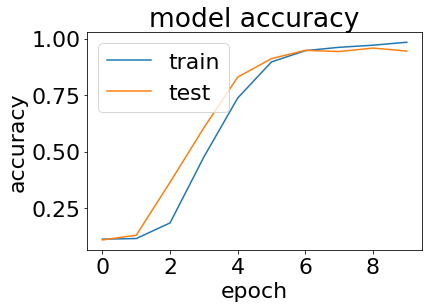

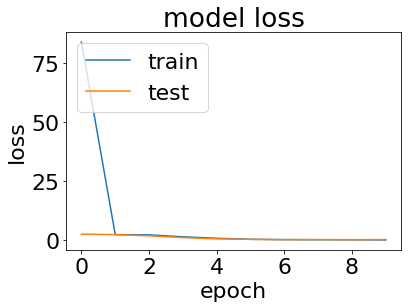

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.ylim([0.9,1])
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim([0,.4])
plt.legend(['train','test'], loc='upper left')
plt.show()

### Save weights

In [22]:
model_json = model.to_json()
model.save_weights('Train_weights_1.h5',overwrite = True)

In [23]:
model.load_weights('Train_weights_1.h5')

## Show architecture distribution

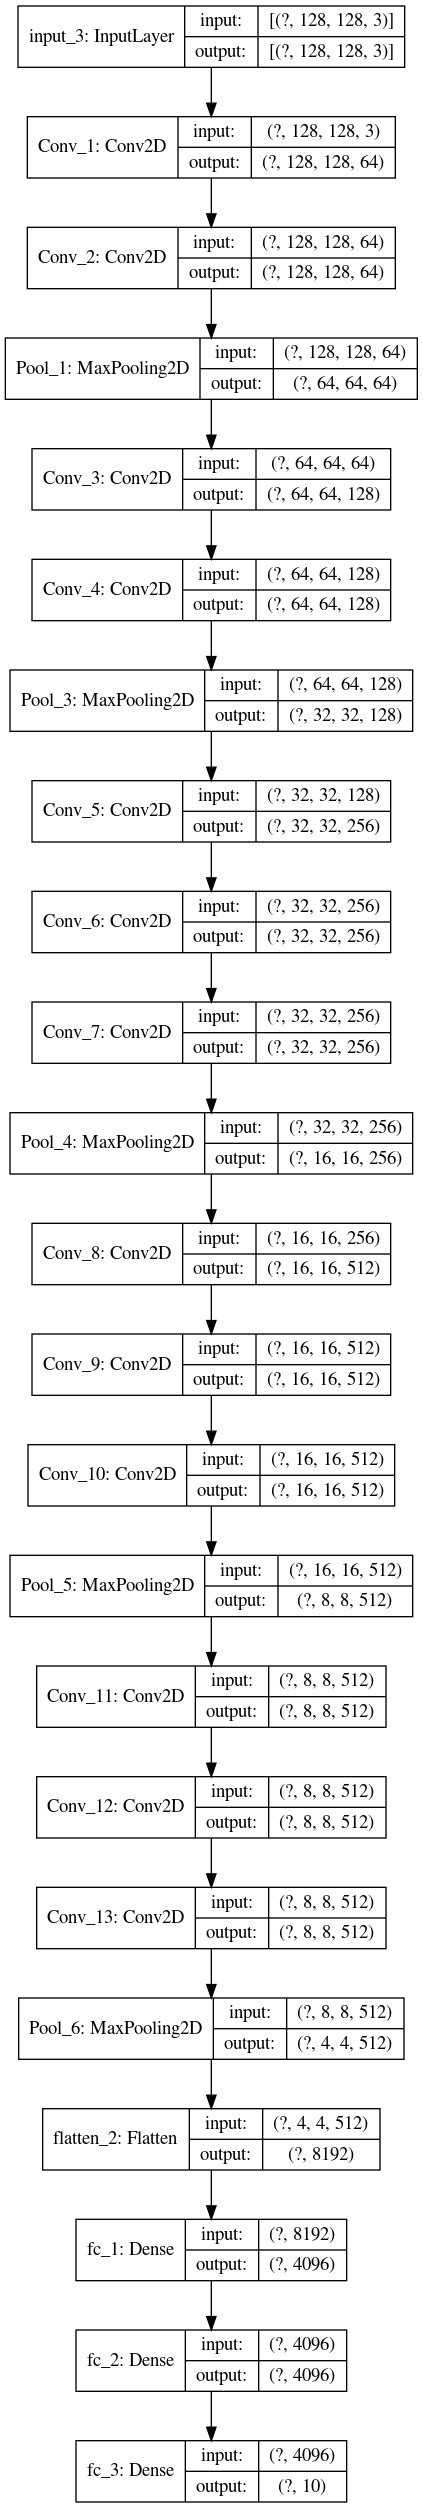

In [24]:
keras.utils.plot_model(model,"model.png",show_shapes = True)

## Predict Test data and create a submission file

In [25]:
df = pd.DataFrame({'img':[],'c0':[], 'c1':[],'c2':[], 'c3':[], 'c4':[],'c5':[], 'c6':[], 'c7':[], 'c8':[], 'c9':[]})
def _submission(pathPropagate_Images,df):
    for imgs in glob.glob(os.path.join(pathPropagate_Images,'*.jpg')):
        img_cv = cv2.imread(imgs)
        img_cv_r = cv2.resize(img_cv,(128,128))
        img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
        arr_predict = model.predict(img_cv_predict,batch_size = 1)
        #print(imgs.split('/')[-1])
        df = df.append(
            {
                'img':imgs.split('/')[-1],
                'c0':round(arr_predict[0][0],2), 
                'c1':round(arr_predict[0][1],2),
                'c2':round(arr_predict[0][2],2),
                'c3':round(arr_predict[0][3],2),
                'c4':round(arr_predict[0][4],2),
                'c5':round(arr_predict[0][5],2),
                'c6':round(arr_predict[0][6],2),
                'c7':round(arr_predict[0][7],2),
                'c8':round(arr_predict[0][8],2),
                'c9':round(arr_predict[0][9],2)
            },
            ignore_index=True
        )
    return df

In [26]:
img_cv = cv2.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_41.jpg")
img_cv_r = cv2.resize(img_cv,(128,128))
img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
arr_predict = model.predict(img_cv_predict,batch_size = 1)

print(arr_predict)
print(round(arr_predict[0][9],2))

[[1.5106487e-01 8.1688922e-05 5.1983892e-07 2.4181169e-03 8.2977858e-05
  2.0872762e-03 3.2270083e-07 1.0960101e-04 1.8510460e-04 8.4396952e-01]]
0.84


[[5.9074862e-10 3.1493083e-13 2.8251973e-06 7.9348895e-15 8.0508783e-10
  2.4851515e-10 9.9998033e-01 1.7979979e-10 1.6860849e-05 2.7850870e-09]]
0.0


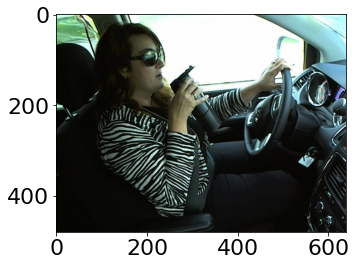

In [27]:
img_cv = cv2.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_4.jpg")
img_cv_r = cv2.resize(img_cv,(128,128))
img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
arr_predict = model.predict(img_cv_predict,batch_size = 1)
plt.imshow(cv2.cvtColor(img_cv , cv2.COLOR_BGR2RGB))
print(arr_predict)
print(round(arr_predict[0][9],2))








In [28]:
llist=[];
for i in range(10): 
    llist.append(arr_predict[0][i]);

print(llist);
a=max( llist);
print(max( llist))
for i in range(len( llist)):
    if a==  llist[i]:
        index=i;
print(index); 
name=["c0: safe driving" , "c1: texting - right", "c2: talking on the phone - right" ,"c3: texting - left" , "c4: talking on the phone - left","c5: operating the radio","c6: drinking","c7: reaching behind","c8: hair and makeup","c9: talking to passenger"];
print(name[index]);

[5.907486e-10, 3.1493083e-13, 2.8251973e-06, 7.9348895e-15, 8.0508783e-10, 2.4851515e-10, 0.99998033, 1.7979979e-10, 1.686085e-05, 2.785087e-09]
0.99998033
6
c6: drinking


In [ ]:
pathPropagate_Images =  "/kaggle/input/state-farm-distracted-driver-detection/imgs/test/"
df = _submission(pathPropagate_Images,df)

In [ ]:
print(df.shape)
df.head(50)

## Save submission file

In [ ]:
df.to_csv('submission_file.csv',index = False)